### Beispiel eines Neuronalen Netzes zur Vorhersage von Kunenabwanderung
Nutzung eines **LSTM** (Long-Short-Term-Memory), welches besonders gut für die Analyse langer Sequenzen geeignet ist.
In unserem Fall sind dies Bestellverläufe verschiedener Kunden.

Import der notwendigen Bibliotheken:
* **Keras** als Hauptframework für Machine Learning (Basiert auf Google's Tensorflow)
* **Numpy** u.a. zur Durchführung von Vektorberechnungen
* **Pandas** für den Import und die Formatierung von Daten 

In [1]:
import random as rn
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from dateutil.relativedelta import relativedelta
from keras import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Masking, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras_preprocessing.sequence import pad_sequences
from numpy.random import seed

ModuleNotFoundError: No module named 'pandas'

Funktion, welche einen *Inner-Join* auf zwei Datensätzen ausführt

In [2]:
def drop_missing_values_vise_versa(df1, df2, column_name):
    drop_condition = df1[column_name].isin(df2[column_name]) == False
    df1 = df1.drop(df1[drop_condition].index)
    drop_condition = df2[column_name].isin(df1[column_name]) == False
    df2 = df2.drop(df2[drop_condition].index)
    return df1, df2

In [3]:
def fill_dates(df, end_date):
    start_date = df['date'].iloc[0]
    if start_date > end_date or len(df) == 0:
        return df
    diff = ((end_date.year - start_date.year) * 12 + end_date.month - start_date.month)
    date_list = [start_date + relativedelta(months=x) for x in range(0, diff)]
    date_frame = pd.DataFrame(date_list)
    date_frame.columns = ['date']
    value = pd.merge(date_frame, df, how='left').fillna(0)
    value = value.drop(['date'], axis=1)
    return value

In [4]:
def train_test_split(df, ratio):
    train = np.array(df[:round(len(df) * ratio)])
    test = np.array(df[-round(len(df) * (1 - ratio)):])
    return train, test

In [5]:
def set_random_seed(s):
    seed(s)
    rn.seed(s)
    tf.random.set_seed(s)

Einlesen der Daten mithilfe von **Pandas**

In [6]:
x_data = pd.read_csv("cleaned_orders.csv", header=0, index_col=0, sep=",", decimal=".", dtype={0:int})
x_data['date'] = pd.to_datetime(x_data.date, format='%Y-%m-%d')
x_data = x_data.drop("quantity", axis=1)
x_data = x_data[x_data.date < '2018-09-01']

In [7]:
y_data = pd.read_csv("cleaned_y_data.csv", header=0, index_col=0, sep=",", dtype={0:int,1:int})
y_data = y_data.sort_values('recipient').reset_index(drop=True)

In [8]:
x_data, y_data = drop_missing_values_vise_versa(x_data, y_data, 'recipient')

In [9]:
# scaler = MinMaxScaler(feature_range=(0,1))
# x_data['sales'] = scaler.fit_transform(np.array(x_data['sales']).reshape(-1,1))

In [10]:
x_data_dict =  dict()
x_data_grouped = x_data.groupby('recipient')
for recipient in x_data_grouped.groups:
    x_data_dict[recipient] = pd.DataFrame(x_data_grouped['date','sales'].get_group(recipient))
assert len(x_data_dict) == len(y_data)

In [11]:
X = list()
for key, item in x_data_dict.items():
    X.append(fill_dates(item, datetime.strptime("2018-09-01","%Y-%m-%d")).values.tolist())

In [12]:
X = pad_sequences(X, value=-1,dtype='float32')
y = np.array(y_data['churned'].values)
y = y.reshape(y.shape[0],1)

In [13]:
split_ratio = 0.7
learning_rate = 0.001
random_seed = 100
lstm_cells = 20
dropout = 0

In [14]:
X_test, X_train = train_test_split(X, 1-split_ratio)
y_test, y_train = train_test_split(y, 1-split_ratio)

In [15]:
set_random_seed(random_seed)
opt = Adam(learning_rate=learning_rate)
model = Sequential()
model.add(Masking(mask_value=-1, input_shape=(X_train.shape[1],1)))
model.add(LSTM(lstm_cells, recurrent_dropout=dropout))
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])

In [16]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, restore_best_weights=True, patience=5)
history = model.fit(x=X_train,y=y_train,epochs=100, verbose=1, callbacks=[es], validation_data=(X_test, y_test))
scores = model.evaluate(X_test, y_test, verbose=0)

Train on 246 samples, validate on 106 samples
Epoch 1/100
246/246 [==============================] - 1s 3ms/step - loss: 0.6323 - acc: 0.6748 - val_loss: 0.6248 - val_acc: 0.6415
Epoch 2/100
246/246 [==============================] - 0s 873us/step - loss: 0.6087 - acc: 0.6911 - val_loss: 0.6032 - val_acc: 0.6415
Epoch 3/100
246/246 [==============================] - 0s 845us/step - loss: 0.5836 - acc: 0.6911 - val_loss: 0.5787 - val_acc: 0.6415
Epoch 4/100
246/246 [==============================] - 0s 865us/step - loss: 0.5621 - acc: 0.6911 - val_loss: 0.5588 - val_acc: 0.6415
Epoch 5/100
246/246 [==============================] - 0s 910us/step - loss: 0.5426 - acc: 0.6911 - val_loss: 0.5376 - val_acc: 0.6415
Epoch 6/100
246/246 [==============================] - 0s 873us/step - loss: 0.5232 - acc: 0.6911 - val_loss: 0.5165 - val_acc: 0.6415
Epoch 7/100
246/246 [==============================] - 0s 894us/step - loss: 0.5004 - acc: 0.6911 - val_loss: 0.4948 - val_acc: 0.6415
Epoch 8/100

Epoch 61/100
246/246 [==============================] - 0s 833us/step - loss: 0.2230 - acc: 0.8862 - val_loss: 0.2453 - val_acc: 0.9245
Epoch 62/100
246/246 [==============================] - 0s 760us/step - loss: 0.2206 - acc: 0.8943 - val_loss: 0.2483 - val_acc: 0.9245
Epoch 63/100
246/246 [==============================] - 0s 760us/step - loss: 0.2175 - acc: 0.8780 - val_loss: 0.2501 - val_acc: 0.9151
Epoch 64/100
246/246 [==============================] - 0s 764us/step - loss: 0.2158 - acc: 0.8902 - val_loss: 0.2573 - val_acc: 0.9245
Epoch 65/100
246/246 [==============================] - 0s 776us/step - loss: 0.2156 - acc: 0.8821 - val_loss: 0.2440 - val_acc: 0.9151
Epoch 66/100
246/246 [==============================] - 0s 817us/step - loss: 0.2146 - acc: 0.9024 - val_loss: 0.2430 - val_acc: 0.9340
Epoch 67/100
246/246 [==============================] - 0s 768us/step - loss: 0.2142 - acc: 0.8943 - val_loss: 0.2446 - val_acc: 0.9245
Epoch 68/100
246/246 [==========================

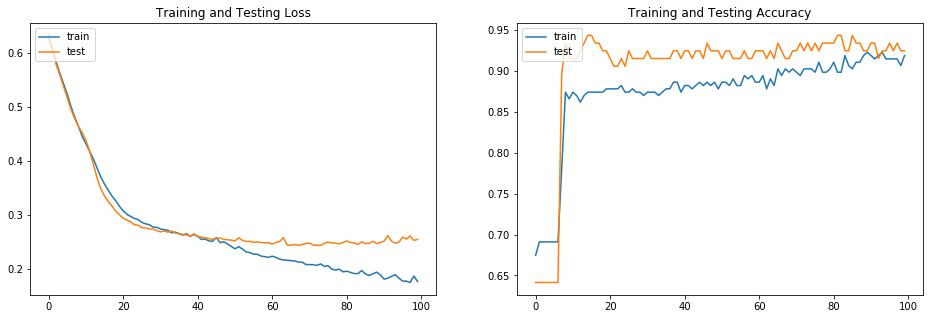

Accuracy: 92.45%
Guessed 98 of 106 Samples correctly!


In [17]:
plt.rcParams["figure.figsize"] = (16, 5)
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(history.history['loss'], label='train')
ax1.plot(history.history['val_loss'], label='test')
ax1.legend(loc="upper left")
ax1.set_title("Training and Testing Loss")
ax2.plot(history.history['acc'], label='train')
ax2.plot(history.history['val_acc'], label='test')
ax2.legend(loc="upper left")
ax2.set_title("Training and Testing Accuracy")
plt.show()

print("Accuracy: %.2f%%" % (scores[1]*100))
print("Guessed " + str(round(X_test.shape[0] * scores[1])) + " of " + str(X_test.shape[0]) + " Samples correctly!")